In [1]:
import sqlite3
import pandas as pd
import numpy as np
import re

In [2]:
# Connecting the data

conn = sqlite3.connect('../data/raw_data_project_m1.db')

sql_code='''
          SELECT personal_info.uuid,country_info.country_code, country_info.rural, career_info.normalized_job_code
          FROM personal_info
          JOIN career_info ON personal_info.uuid=career_info.uuid
          JOIN country_info ON personal_info.uuid=country_info.uuid
          JOIN poll_info ON personal_info.uuid=poll_info.uuid
          '''
raw_data_df=pd.DataFrame(pd.read_sql_query(sql_code, conn))

raw_data_df.head()
# raw_df.info()

,uuid,country_code,rural,normalized_job_code
0,0001afe0-da16-0133-9d54-0a81e8b09a82,NL,city,7932d4705d002b47789c11edfaed685e
1,00073240-d995-0133-f7e1-0a81e8b09a82,HR,Country,None
2,0007b2d0-daf3-0133-c5f0-0a81e8b09a82,DE,rural,e7b3e1c6a32c7247cd4857e4c3574165
3,00199e00-d8c3-0133-c6b2-0a81e8b09a82,IT,rural,None
4,0028cc20-dcc4-0133-f408-0a81e8b09a82,FR,rural,None


In [3]:
# Cleaning Rural
def rural_names(x):
    if x == 'countryside':
        return 'Rural'
    if x == 'urban':
        return 'Urban'
    if x == 'city':
        return 'Urban'
    if x == 'Country':
        return 'Rural'
    if x == 'rural':
        return 'Rural'
    if x == 'Non-Rural':
        return 'Urban'
    
        raw_data_df['rural'] = raw_data_df['rural'].replace('Rural', 'countryside')
    raw_data_df['rural'] = raw_data_df['rural'].replace('Urban', 'urban')
    raw_data_df['rural'] = raw_data_df['rural'].replace('Urban', 'city')
    raw_data_df['rural'] = raw_data_df['rural'].replace('Rural', 'Country')
    raw_data_df['rural'] = raw_data_df['rural'].replace('Rural', 'rural')
    raw_data_df['rural'] = raw_data_df['rural'].replace('Rural', 'Non-Rural')

In [4]:
# change rural into Rural
raw_data_df['Rural'] = raw_data_df['rural'].apply(rural_names)
raw_data = raw_data_df[['uuid', 'country_code', 'Rural', 'normalized_job_code']]
raw_data.head()
#raw_data['Rural'].unique()

,uuid,country_code,Rural,normalized_job_code
0,0001afe0-da16-0133-9d54-0a81e8b09a82,NL,Urban,7932d4705d002b47789c11edfaed685e
1,00073240-d995-0133-f7e1-0a81e8b09a82,HR,Rural,None
2,0007b2d0-daf3-0133-c5f0-0a81e8b09a82,DE,Rural,e7b3e1c6a32c7247cd4857e4c3574165
3,00199e00-d8c3-0133-c6b2-0a81e8b09a82,IT,Rural,None
4,0028cc20-dcc4-0133-f408-0a81e8b09a82,FR,Rural,None


In [5]:
# API
import requests
import json

url = 'http://api.dataatwork.org/v1/jobs/'
job_title_requests = []
jobs_unique_values = raw_data['normalized_job_code'].unique()

for value in jobs_unique_values:
    response_data = requests.get(f'{url}{value}').json()
    if list(response_data.keys())[0] == 'error':
        pass
    else:
        job_title_requests.append(response_data)
        
print('ending...')

ending...


In [6]:
job_title_requests[:5]

[{'uuid': '7932d4705d002b47789c11edfaed685e',
  'title': 'Data Control Assistant',
  'normalized_job_title': 'data control assistant',
  'parent_uuid': '1b7a3048ca875e752dbe1ec6368e2e9a'},
 {'uuid': 'e7b3e1c6a32c7247cd4857e4c3574165',
  'title': 'Data Processing Systems Analyst',
  'normalized_job_title': 'data processing systems analyst',
  'parent_uuid': '0148f61d4227497728ce33490843d056'},
 {'uuid': '04c82eae29e1c4a30eac0710b74ab276',
  'title': 'Database Marketing Analyst',
  'normalized_job_title': 'database marketing analyst',
  'parent_uuid': '05d507b5052f3f105eb5602c10723103'},
 {'uuid': '3161063d378eecc4581c5cdee46a2a6c',
  'title': 'Head of Information Systems and Data Processing',
  'normalized_job_title': 'head of information systems and data processing',
  'parent_uuid': 'bb4e5066e69e4228172b4850d2a920f4'},
 {'uuid': 'e2f68bf748aea2c7d2254550c0c92b23',
  'title': 'Director of Data Operations',
  'normalized_job_title': 'director of data operations',
  'parent_uuid': 'bb4e5

In [7]:
# uuid values
job_uuid_list = []
for uuid_item in job_title_requests:
    try:
        job_uuid_list.append(uuid_item['uuid'])
    except:
        pass

In [8]:
# title values
job_titles_job_list = []

for title_item in job_title_requests:
    try:
        job_titles_job_list.append(title_item['title'])
    except:
        pass

In [9]:
dict_job_id_titles_value = dict(zip(job_uuid_list, job_titles_job_list))

In [10]:
raw_data['Job Title'] = raw_data['normalized_job_code']

for uuid, title in dict_job_id_titles_value.items():
    raw_data.loc[raw_data['normalized_job_code'] == uuid, 'Job Title'] = title

In [11]:
raw_data[['uuid', 'country_code', 'Rural', 'Job Title', 'normalized_job_code']].head()

,uuid,country_code,Rural,Job Title,normalized_job_code
0,0001afe0-da16-0133-9d54-0a81e8b09a82,NL,Urban,Data Control Assistant,7932d4705d002b47789c11edfaed685e
1,00073240-d995-0133-f7e1-0a81e8b09a82,HR,Rural,None,None
2,0007b2d0-daf3-0133-c5f0-0a81e8b09a82,DE,Rural,Data Processing Systems Analyst,e7b3e1c6a32c7247cd4857e4c3574165
3,00199e00-d8c3-0133-c6b2-0a81e8b09a82,IT,Rural,None,None
4,0028cc20-dcc4-0133-f408-0a81e8b09a82,FR,Rural,None,None


In [12]:
# Web scraping

import requests
from bs4 import BeautifulSoup

In [13]:
url = 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Glossary:Country_codes'
html = requests.get(url).content
soup = BeautifulSoup(html, 'html.parser')

In [14]:
table = soup.find_all('div', {'class': 'mw-content-ltr'})[0]
countries_data = table.find_all('table')
countries_names = [info.text for info in countries_data]

In [15]:
#countries_names[:7]

In [16]:
# using regular expressions in order to clean countries data

cleaning_spaces = [re.sub(r'\s', '', i) for i in countries_names]
#cleaning_spaces
cleaning_special_characters = [re.sub(r'\*', '', i) for i in cleaning_spaces]
#cleaning_special_characters
cleaning_brackets = [re.sub(r'\[\d\]', '', i) for i in cleaning_special_characters]
#cleaning_brackets

In [17]:
countries_scrapping_data = ''.join(cleaning_brackets)
#countries_scrapping_data

In [18]:
# separating keys and values in order to convert it in a dictionary 
countries_values = re.split(r'\(\w{0,7}\)', countries_scrapping_data)
countries_keys = re.findall(r'\(\w{0,7}\)', countries_scrapping_data)
countries_keys = [re.sub(r'\(|\)', '', i) for i in countries_keys]
dict_keys_values_countries = dict(zip(countries_keys, countries_values))

In [19]:
# adding missing countries
dict_keys_values_countries['GB'] = 'Great Britain'
dict_keys_values_countries['GR'] = 'Greece'

In [20]:
# adding countries to the dataframe
raw_data['Country'] = raw_data['country_code']
for keys, values in dict_keys_values_countries.items():
    raw_data.loc[raw_data['country_code'] == keys, 'Country'] = values

In [21]:
raw_data.head()

,uuid,country_code,Rural,normalized_job_code,Job Title,Country
0,0001afe0-da16-0133-9d54-0a81e8b09a82,NL,Urban,7932d4705d002b47789c11edfaed685e,Data Control Assistant,Netherlands
1,00073240-d995-0133-f7e1-0a81e8b09a82,HR,Rural,None,None,Croatia
2,0007b2d0-daf3-0133-c5f0-0a81e8b09a82,DE,Rural,e7b3e1c6a32c7247cd4857e4c3574165,Data Processing Systems Analyst,Germany
3,00199e00-d8c3-0133-c6b2-0a81e8b09a82,IT,Rural,None,None,Italy
4,0028cc20-dcc4-0133-f408-0a81e8b09a82,FR,Rural,None,None,France


In [22]:
raw_data = raw_data[['uuid', 'Country', 'Job Title', 'Rural']]
#raw_data.head()

In [23]:
# adding Quantity and Percentage
rows_counts = dict(raw_data['Job Title'].value_counts())
percentage_calculate = raw_data['Job Title'].count()

for i in raw_data.index:
    if raw_data.loc[i, 'Job Title'] == None:
        pass
    else:
        raw_data.loc[i, 'Quantity'] = rows_counts[raw_data.loc[i, 'Job Title']]
        raw_data.loc[i, 'Percentage'] = rows_counts[raw_data.loc[i, 'Job Title']] * 100 / percentage_calculate

In [24]:
raw_final = raw_data.dropna(subset=['Job Title', 'Quantity'])

In [25]:
raw_final.head()

,uuid,Country,Job Title,Rural,Quantity,Percentage
0,0001afe0-da16-0133-9d54-0a81e8b09a82,Netherlands,Data Control Assistant,Urban,8.0,0.140302
2,0007b2d0-daf3-0133-c5f0-0a81e8b09a82,Germany,Data Processing Systems Analyst,Rural,76.0,1.332866
5,002b2140-da48-0133-58d3-0a81e8b09a82,Sweden,Database Marketing Analyst,Urban,61.0,1.069800
7,0035b420-d95a-0133-5d4f-0a81e8b09a82,Spain,Head of Information Systems and Data Processing,Urban,71.0,1.245177
9,0042eb40-d943-0133-c7f4-0a81e8b09a82,Bulgaria,Director of Data Operations,Urban,78.0,1.367941


In [26]:
raw_final['Quantity'] = raw_final['Quantity'].astype('int64')
raw_final['Percentage'] = raw_final['Percentage'].astype(float).map(lambda x: '{:.2%}'.format(x))

<ipython-input-26-159b2706be45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_final['Quantity'] = raw_final['Quantity'].astype('int64')
<ipython-input-26-159b2706be45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_final['Percentage'] = raw_final['Percentage'].astype(float).map(lambda x: '{:.2%}'.format(x))


In [27]:
raw_final = raw_final.sort_values(['Quantity', 'Percentage'])
raw_final.head()

,uuid,Country,Job Title,Rural,Quantity,Percentage
2876,4ddd1330-d8be-0133-0e2a-0a81e8b09a82,Great Britain,Data Center Manager,Urban,4,7.02%
4624,7baed400-db5a-0133-30f3-0a81e8b09a82,Great Britain,Database Technician,Urban,4,7.02%
5058,86f60570-dd43-0133-2b30-0a81e8b09a82,Germany,Data Center Manager,Rural,4,7.02%
5261,8bdab6c0-da7b-0133-8a6a-0a81e8b09a82,Poland,Database Technician,Urban,4,7.02%
6905,b7d4cdc0-dcb1-0133-92aa-0a81e8b09a82,Spain,Database Technician,Urban,4,7.02%


In [28]:
# selecting an option



In [29]:
raw_final['Job Title'].unique()

array(['Data Center Manager', 'Database Technician', 'Data Reviewer',
       'Clinical Trials Data Coordinator', 'Data Processing Mechanic',
       'Data Examination Clerk', 'Data Capture Specialist',
       'Data Abstractor', 'Data Processing Clerk',
       'Data Management Manager', 'Data Processing Control Clerk',
       'Data Control Assistant', 'Data Capture Clerk',
       'Clinical Data Specialist',
       'Data Processing Auxiliary Equipment Operator', 'Data Analyst',
       'Operations Officer, Afloat (Naval Tactical Data Systems)',
       'Crime Data Specialist', 'Data Control Clerk Supervisor',
       'Data Processing Supervisor', 'Scientific Database Curator',
       'Maintenance Data Analyst', 'Reference Data Expert',
       'Data Collector', 'Data Keyer', 'Data Entry Operator',
       'Clinical Data Analyst', 'Data Technician', 'Datastage Developer',
       'Data Specialist', 'Data Entry Associate', 'Data Entry Technician',
       'Database Administrator (DBA)',
       'We

In [30]:
import matplotlib.pyplot as plt

In [31]:
%matplotlib inline

In [32]:
x = raw_final['Country'][:5]

In [33]:
y = raw_final['Quantity'][:5]

In [34]:
z = raw_final['Percentage'][:5]

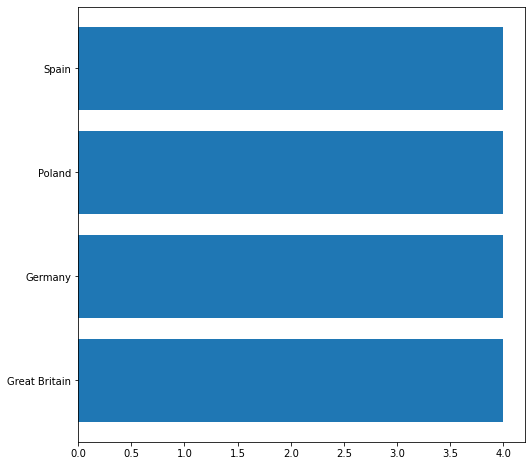

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
ax.barh(x,y);

In [36]:
#fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,10));

#ax.set_title('Countries per Quantity')
#ax.barh(x,y);

In [37]:
plt.style.use('ggplot')

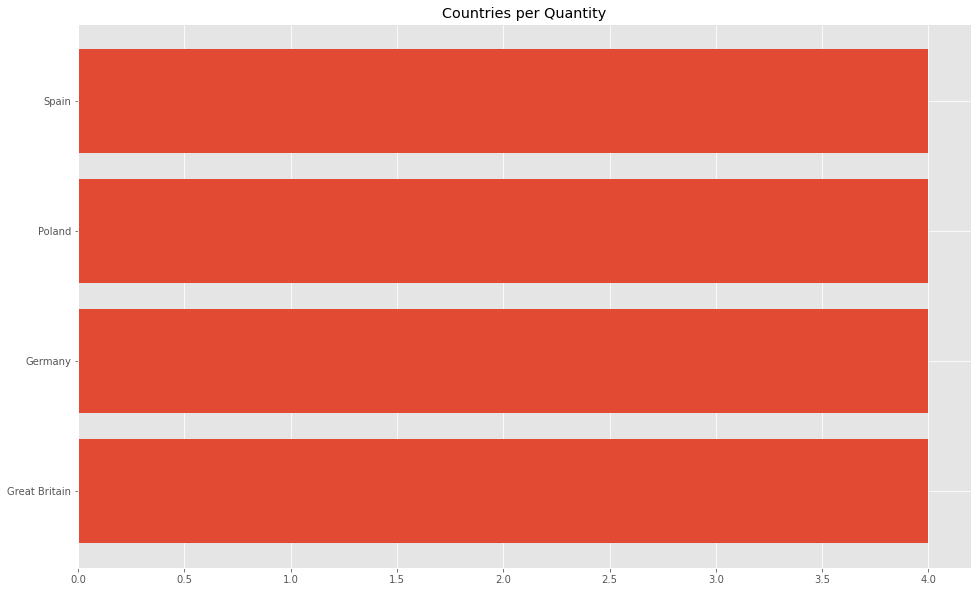

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,10));

ax.set_title('Countries per Quantity')
ax.barh(x,y);

In [49]:
import smtplib

In [50]:
#help(smtplib)

In [58]:
import smtplib

# import the corresponding modules
from email import encoders
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

port = 587 
smtp_server = "smtp-mail.gmail.com"
login = "08420bb5e8c8a7" # paste your login generated by Mailtrap
password = "6d54c85cbcb506" # paste your password generated by Mailtrap

subject = "An example of boarding pass"
sender_email = "m.fernandezban@gmail.com"
receiver_email = "m.fernandezban@gmail.com"

message = MIMEMultipart()
message["From"] = sender_email
message["To"] = receiver_email
message["Subject"] = subject

# Add body to email
body = "This is an example of how you can send a boarding pass"
message.attach(MIMEText(body, "plain"))

filename = "../results/all_countries_data.csv"
# Open PDF file in binary mode

# We assume that the file is in the directory where you run your Python script from
with open(filename, "rb") as attachment:
    # The content type "application/octet-stream" means that a MIME attachment is a binary file
    part = MIMEBase("application", "octet-stream")
    part.set_payload(attachment.read())

# Encode to base64
encoders.encode_base64(part)

# Add header 
part.add_header(
    "Content-Disposition",
    f"attachment; filename= {filename}",
)

# Add attachment to your message and convert it to string
message.attach(part)
text = message.as_string()

# send your email
with smtplib.SMTP("smtp.mailtrap.io", 2525) as server:
    server.login(login, password)
    server.sendmail(
        sender_email, receiver_email, text
    )
print('Sent')

Sent
